In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

In [11]:
def plotimage(img, sub1, sub2, sub3):
    plt.subplot(sub1, sub2, sub3)
    if(len(img.shape) < 3):
        plt.imshow(img, cmap='gray')
    else :
        imgshow = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)           
        plt.imshow(imgshow)
    plt.axis('off')    

In [12]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2)))

In [13]:
def findshapepoint(cnt,r):
    cnt_len = cv2.arcLength(cnt, True) #計算週長  
    approx = cv2.approxPolyDP(cnt, r*cnt_len, True) #多邊形逼近 (https://stackoverflow.com/questions/59926449/opencv-shape-detection)
    return approx

In [18]:
def find_squares(img):
    
    #step1 : 基礎處理
    kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
    img = cv2.filter2D(img,-1,kernel)  # 銳化 : https://en.wikipedia.org/wiki/Kernel_(image_processing)
    img = cv2.GaussianBlur(img,(3,3),0) #高斯濾波
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.convertScaleAbs(img, alpha=0.5, beta=-10)
    
    #step2 : 二值化邊緣運算
    squares = []
    for sensitivity in [0,20,40,60,90]:
        threshold, image_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        retval, bins = cv2.threshold(img, threshold+sensitivity, 255, cv2.THRESH_BINARY)
        image_MORPH = cv2.morphologyEx(bins, cv2.MORPH_GRADIENT, np.ones((3,3),np.uint8)) ##MORPH_GRADIENT /MORPH_CLOSE/ MORPH_OPEN/ cv2.Canny(bins, 20, 255)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        dilated = cv2.dilate(image_MORPH, kernel)
        contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL/ RETR_TREE/ RETR_CCOMP /RETR_LIST (無階層)  #CHAIN_APPROX_SIMPLE/CHAIN_APPROX_NONE 
        if hierarchy is not None :
            for index in range(len(hierarchy[0])):
                #if hierarchy[0][index][3] == -1:  #First_Child =-1 ； https://docs.opencv.org/4.5.1/d9/d8b/tutorial_py_contours_hierarchy.html
                    cnt=contours[index]
                    x, y, w, h = cv2.boundingRect(cnt)
                    if cv2.contourArea(cnt) > 1600 and cv2.contourArea(cnt) < 6000 and (w/h) > 0.5 and (w/h) < 2 and w<100 and h<100 : #and cv2.isContourConvex(cnt)  len(cnt) >= 4 and 
                        #cnt = cnt.reshape(-1, 2) #https://www.zhihu.com/question/52684594
                        #max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                        #if max_cos < 0.1 :
                        squares.append(cnt)
                        
                        
    # step3 : Merge contour using mask
    mask = np.ones(img.shape[:2], dtype="uint8") * 0 
    merge_contour=cv2.drawContours(mask, squares, -1, 255, -1) #-1為填滿
    merge_cont, merge_hia = cv2.findContours(merge_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # step4 : bboxs
    bboxs=[]
    for cont in merge_cont:
        x, y, w, h = cv2.boundingRect(cont)
        bboxs.append((x,y,x+w,y+h))
    
    # step 4 : 多方形逼近，找出非4點矩形
    touch=0
    for cnts in merge_cont:
        approx=findshapepoint(cnts,0.05)
        if len(approx) > 4 : #4個角為正方形，若不是正方形即為碰邊
            touch+=1
    
    return touch,merge_cont,bboxs,img,bins,image_MORPH

In [19]:
def drawBoundingBox(img, bboxs):
    for box in bboxs:
        x1,y1,x2,y2 = (box[0], box[1], box[2], box[3])
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 6)
    return img

In [20]:
def ROI_APtouch(img):
    
    #step1 : 基礎處理
    kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
    
    img = cv2.GaussianBlur(img,(3,3),0) #高斯濾波
    #img = cv2.medianBlur(img,3) #中值濾波
    img = cv2.filter2D(img,-1,kernel)  # 銳化 : https://en.wikipedia.org/wiki/Kernel_(image_processing)
    img = cv2.filter2D(img,-1,kernel)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.convertScaleAbs(img, alpha=0.5, beta=-10) # alpha(Contrast)=0-3.0 / beta(Brightness)=0-100
    
    #step2 : 二值化 邊緣運算
    threshold, image_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    retval, bins = cv2.threshold(img, threshold+0, 255, cv2.THRESH_BINARY)
    bins2=bins.copy()
    
    #step3 : 創建mask過濾 7*7雜點
    mask = np.ones(img.shape[:2], dtype="uint8") * 0
    mask_cnts, mask_hias = cv2.findContours(bins, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    noise=[]
    for mc in mask_cnts:
        if cv2.contourArea(mc)<49:
            noise.append(mc)
    mask=cv2.drawContours(mask, noise, -1, 255, -1) #填滿
    mask_line=cv2.drawContours(mask, noise, -1, 0, 1) #外框
    mask=cv2.add(mask,mask_line) #去除外框
    masked = cv2.bitwise_not(bins, bins, mask=mask) #bitwise_not/ bitwise_and
    
    #step4 : 邊緣運算
    image_MORPH = cv2.morphologyEx(masked, cv2.MORPH_OPEN, np.ones((2,2),np.uint8))  #MORPH_GRADIENT /MORPH_CLOSE/ MORPH_OPEN/ cv2.Canny(bins, 20, 255)
    contours, hierarchy = cv2.findContours(image_MORPH, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL/ RETR_TREE/ RETR_CCOMP /RETR_LIST (無階層)
    
    #step5 : 找最佳邊緣
    btm_level=np.max(hierarchy[0][:,3]) #最底層的邊緣
    ROI_contour = []
    if hierarchy is not None :
        exit_flag = False
        for level in range(btm_level, -2, -1):
            for index in range(len(hierarchy[0])):
                cnt=contours[index]
                if hierarchy[0][index][3] == level :
                    x, y, w, h = cv2.boundingRect(cnt)
                    if cv2.contourArea(cnt) > 1500 and cv2.contourArea(cnt) < 6000 and (w/h) > 0.5 and (w/h) < 2 and w<100 and h<100 :
                        cnt = cv2.approxPolyDP(cnt, 8, True)
                        ROI_contour.append(cnt)
                        exit_flag = True
            if exit_flag:
                break
    
    return ROI_contour,img,bins2,masked,image_MORPH

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


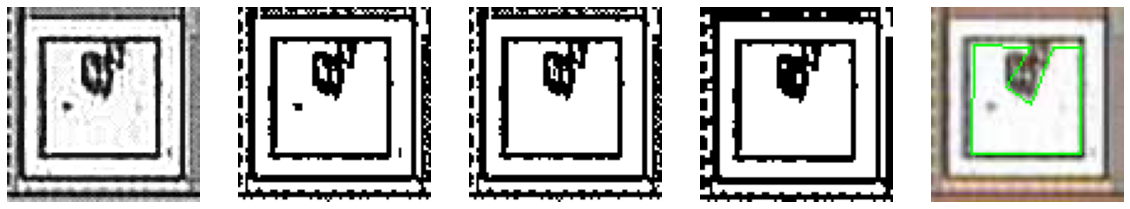

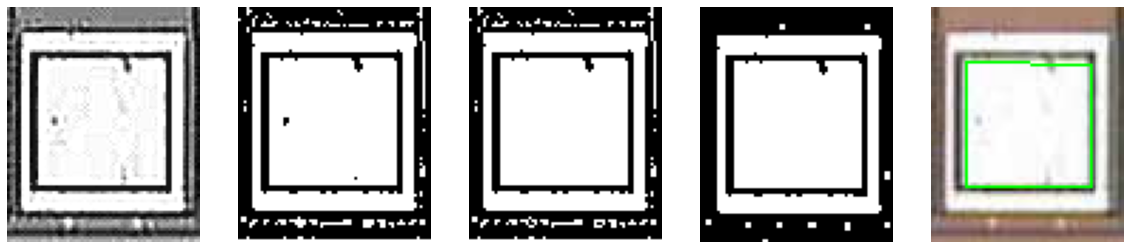

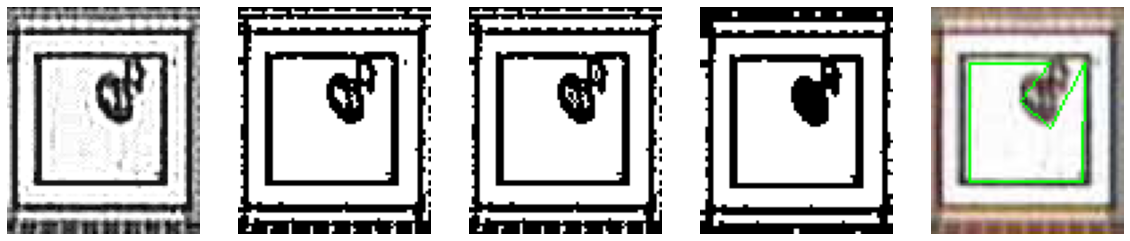

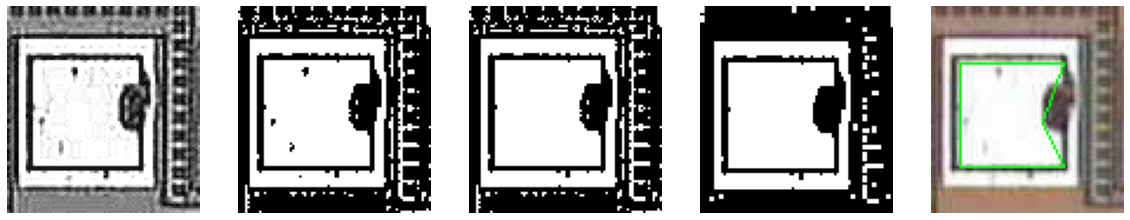

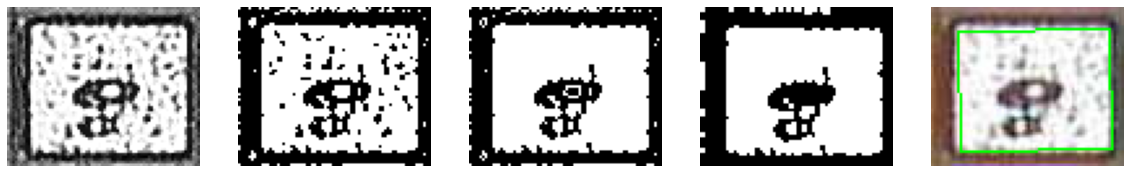

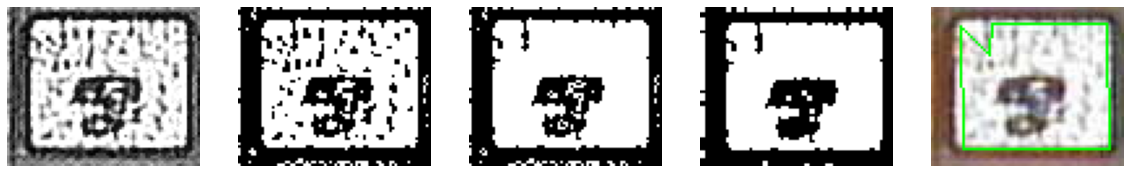

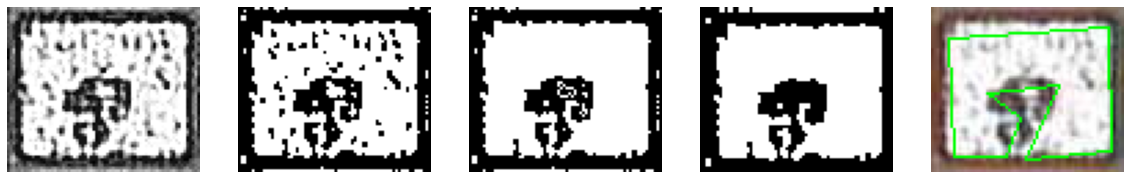

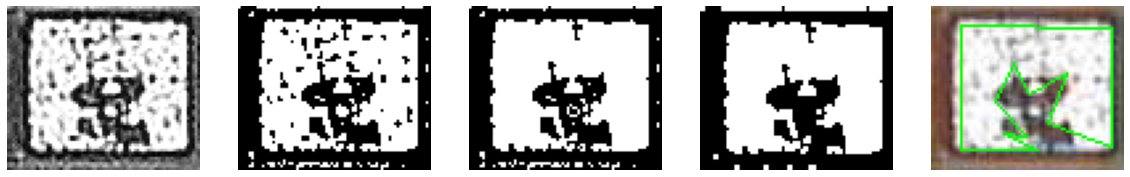

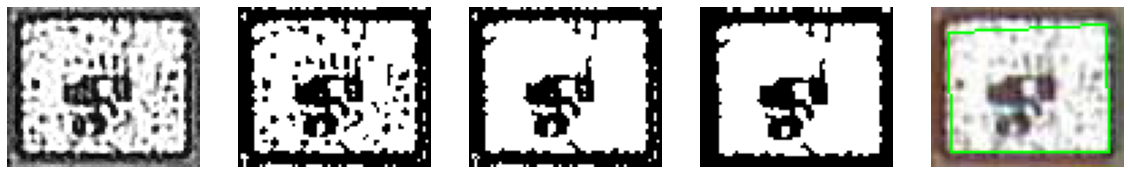

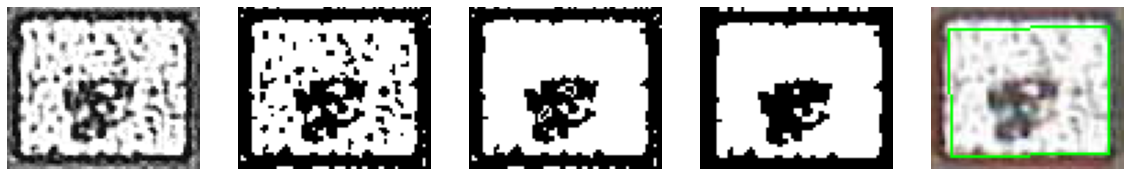

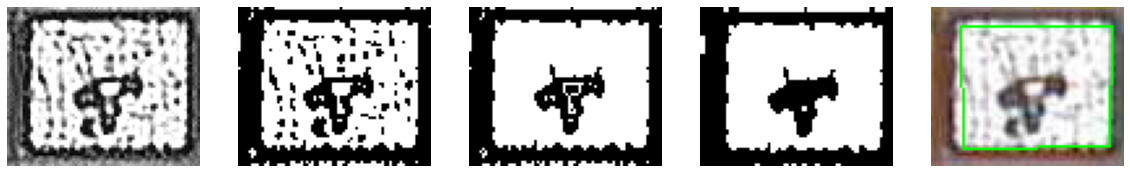

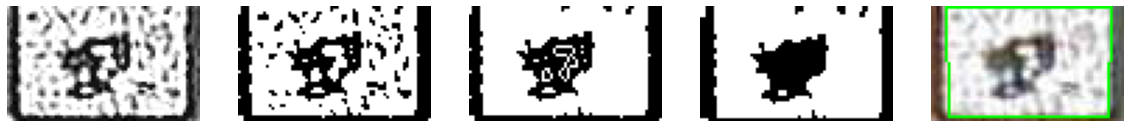

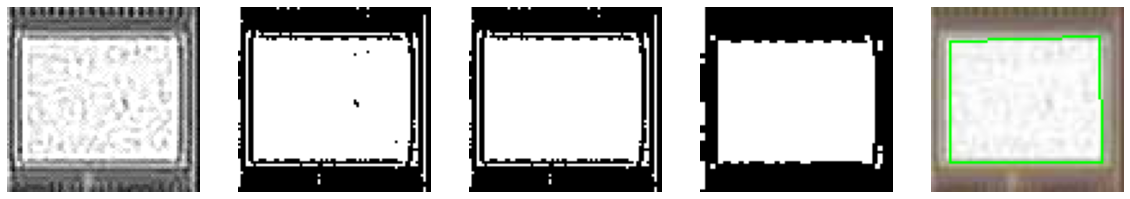

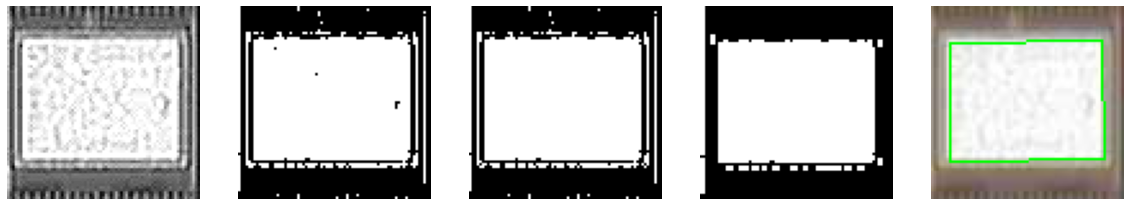

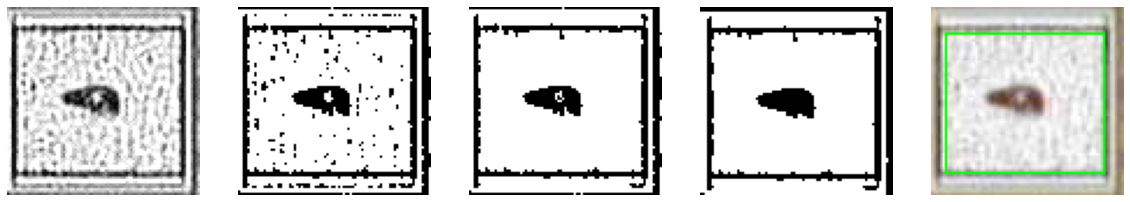

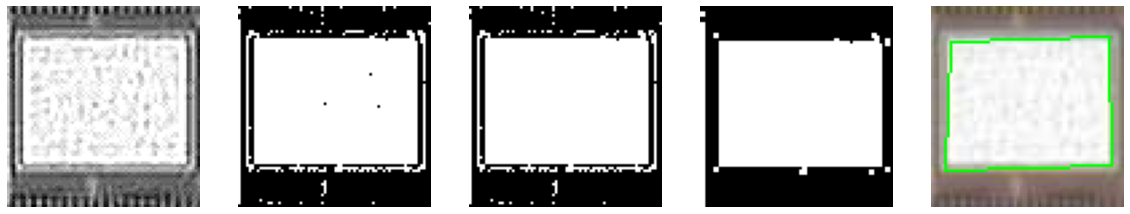

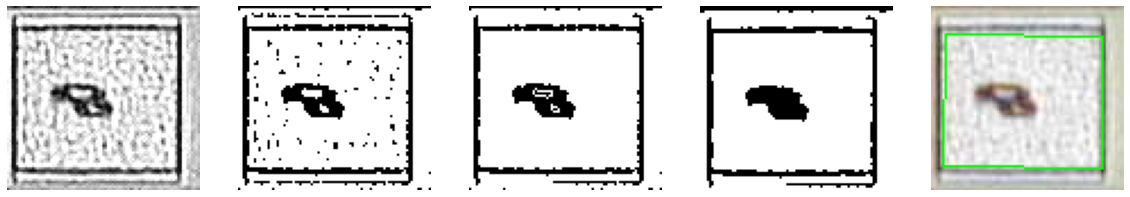

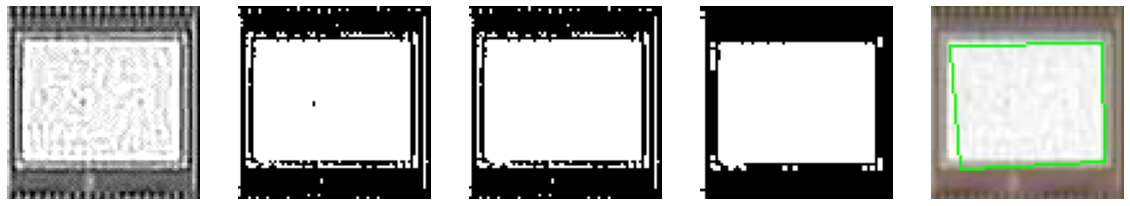

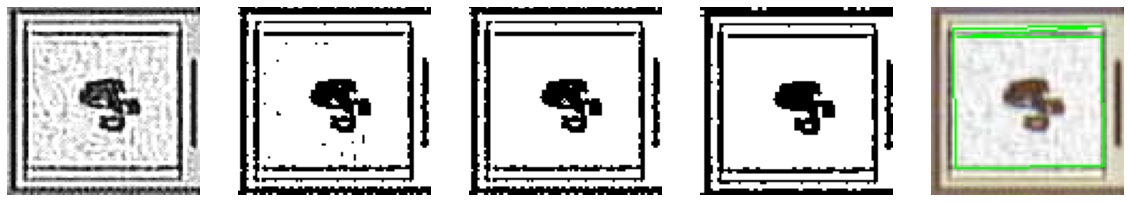

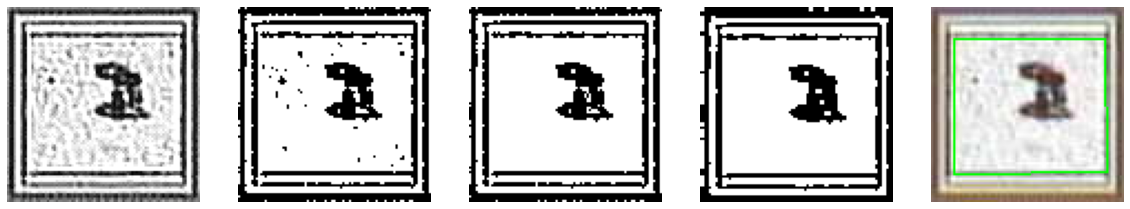

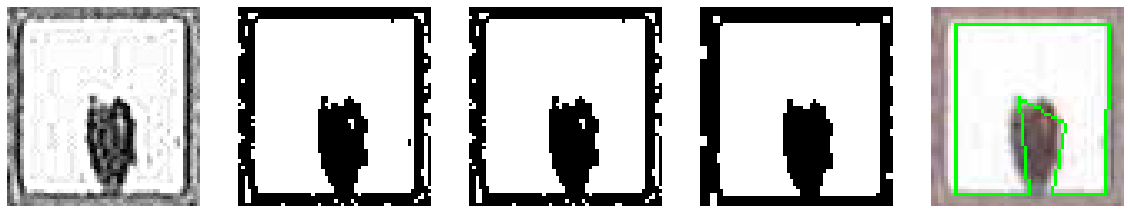

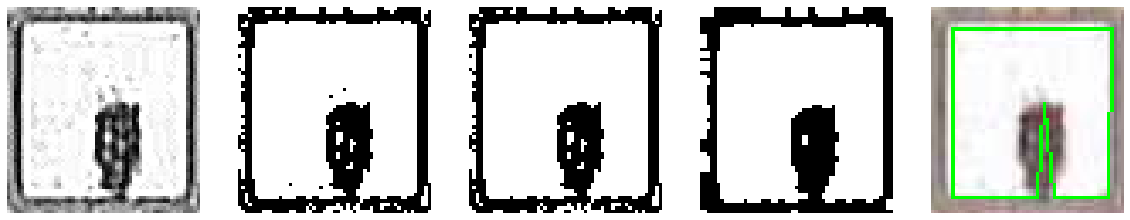

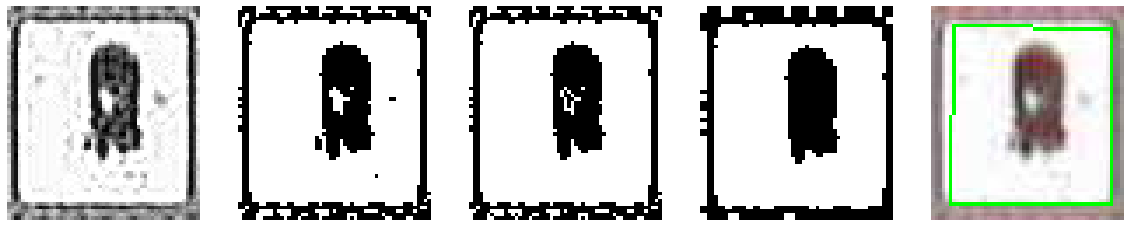

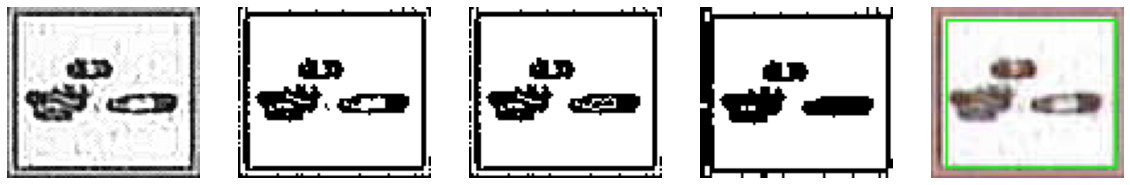

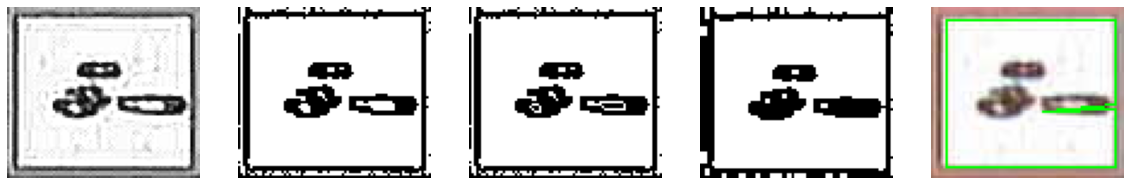

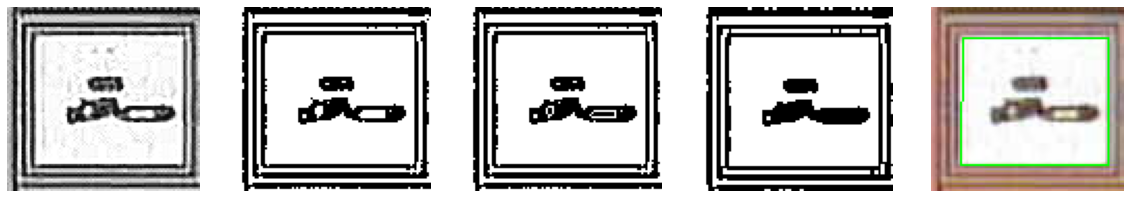

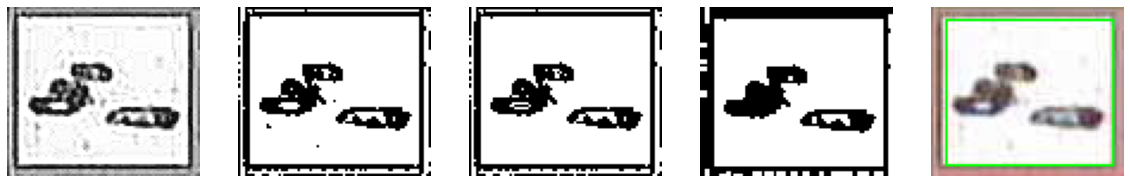

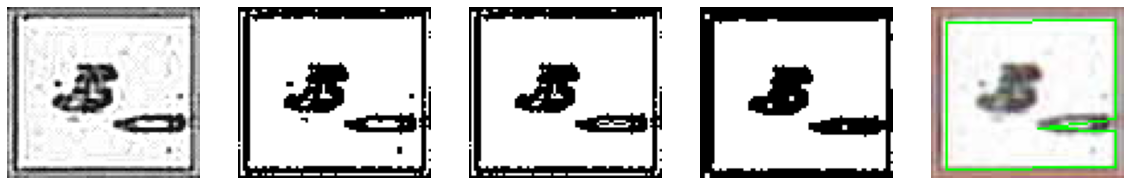

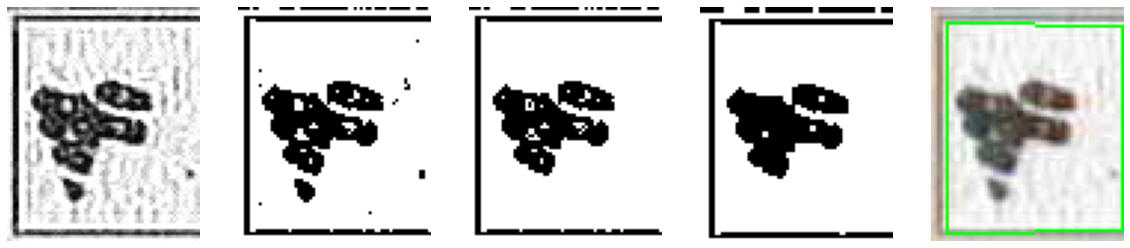

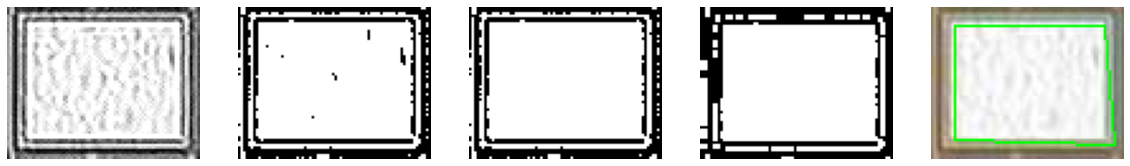

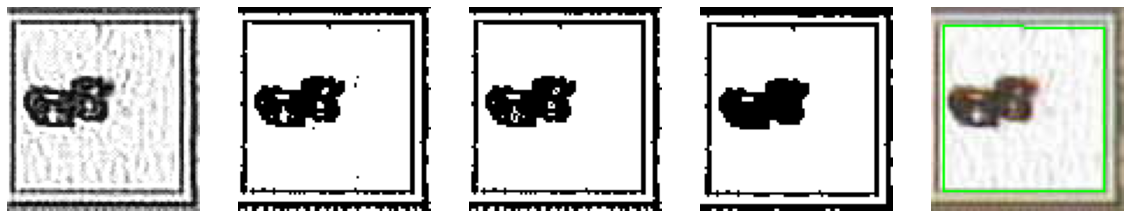

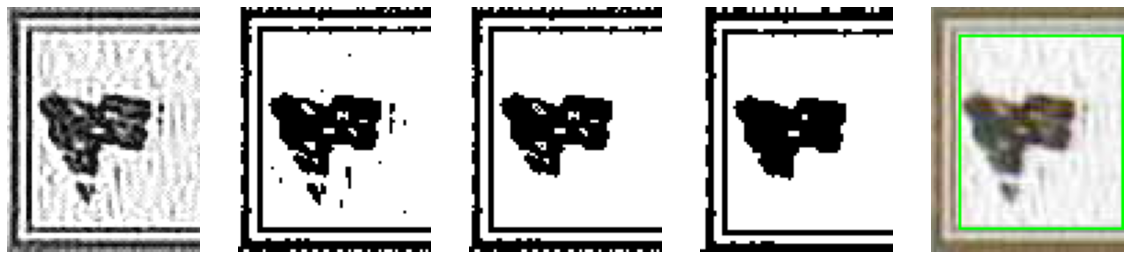

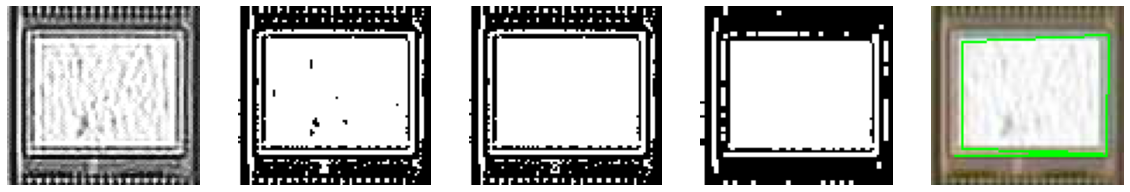

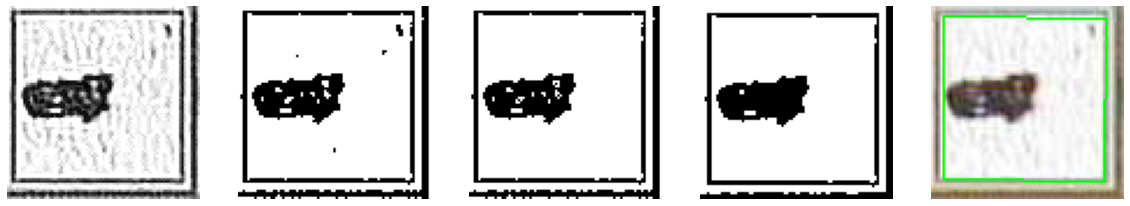

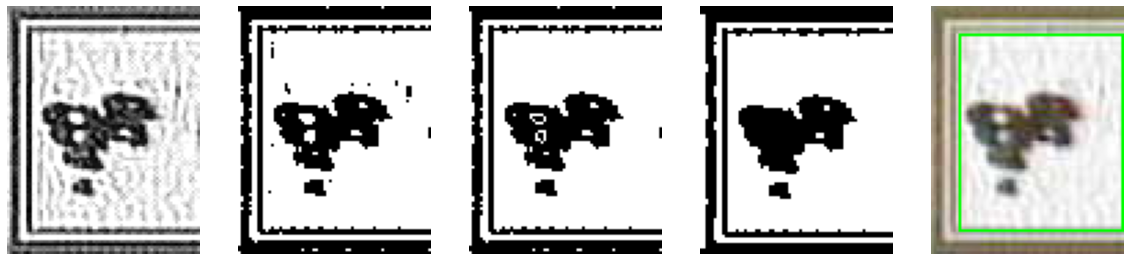

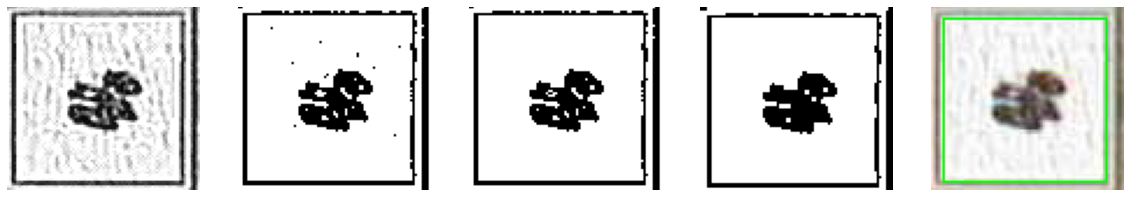

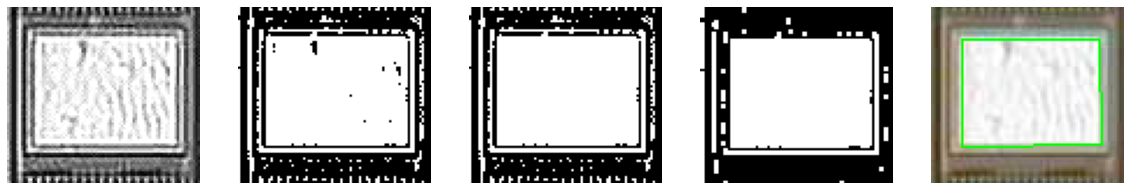

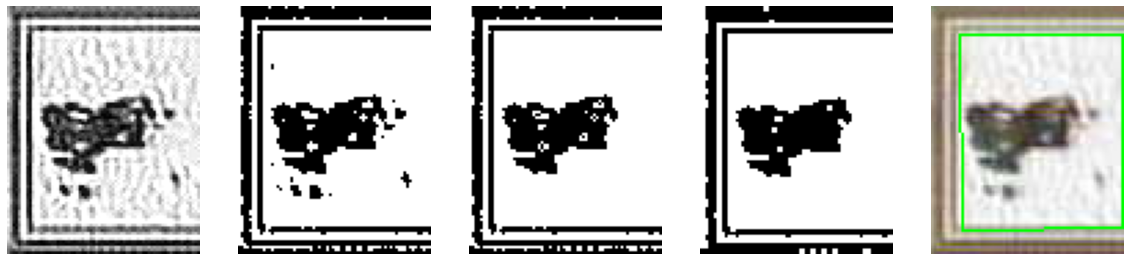

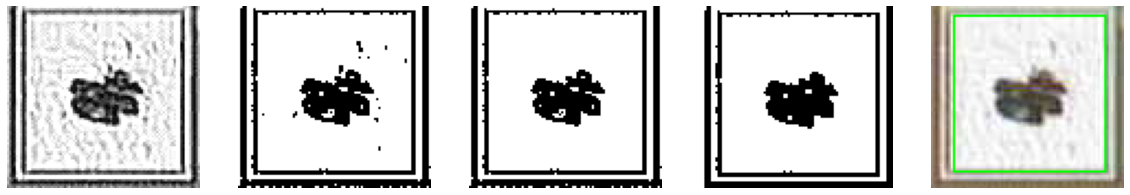

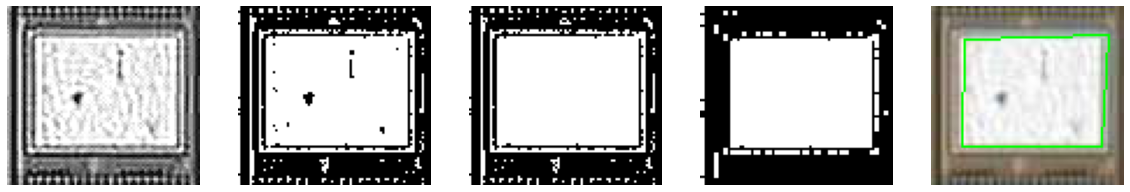

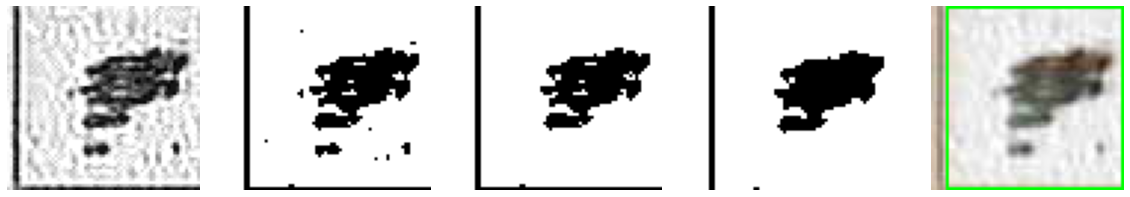

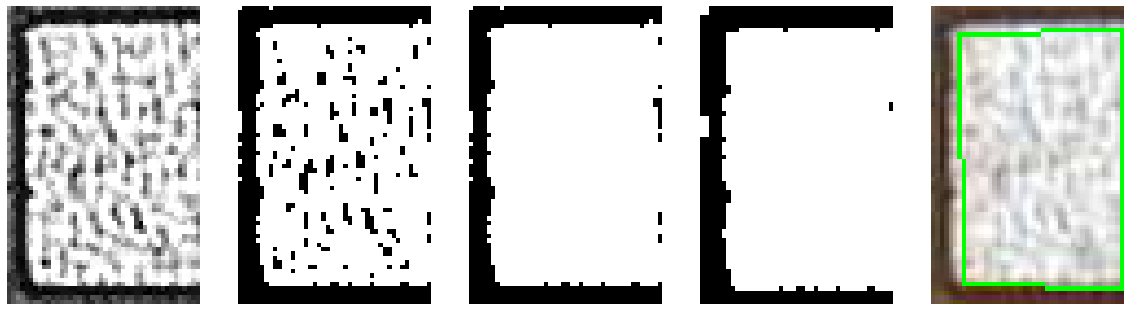

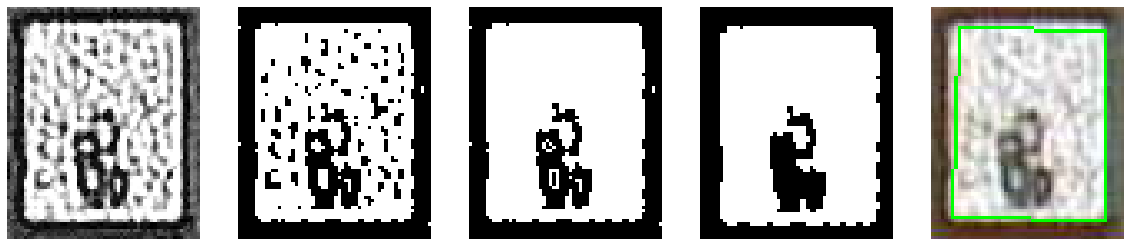

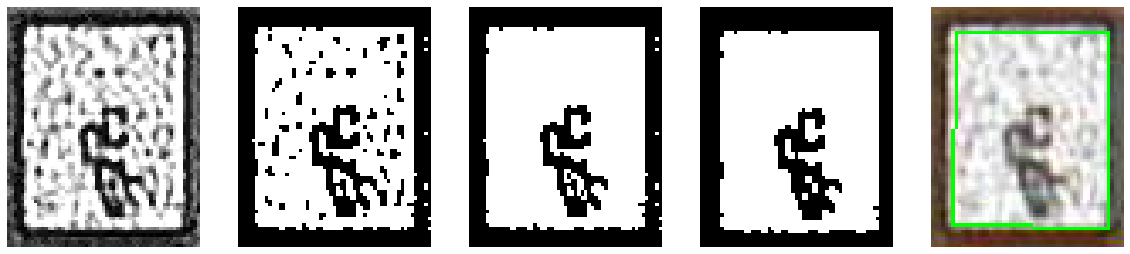

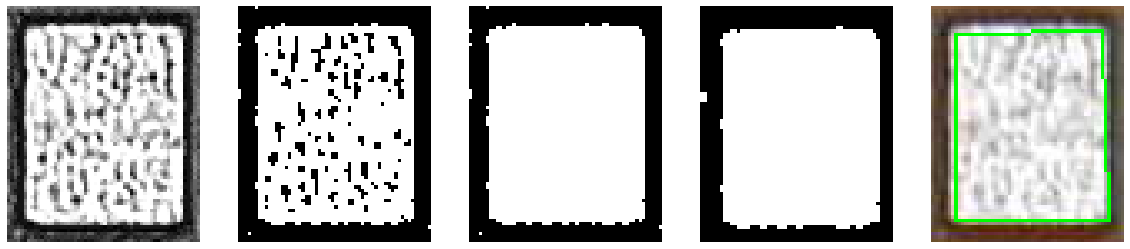

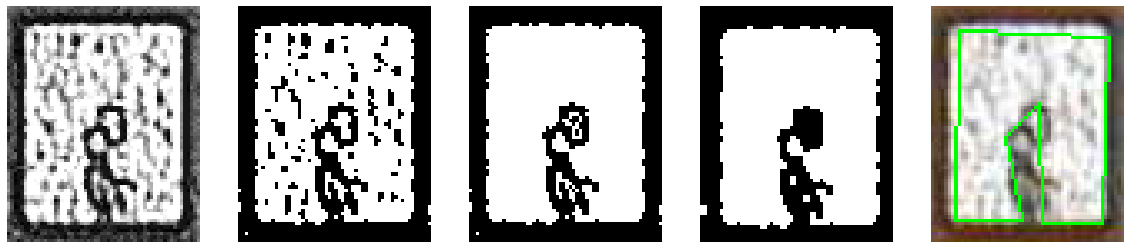

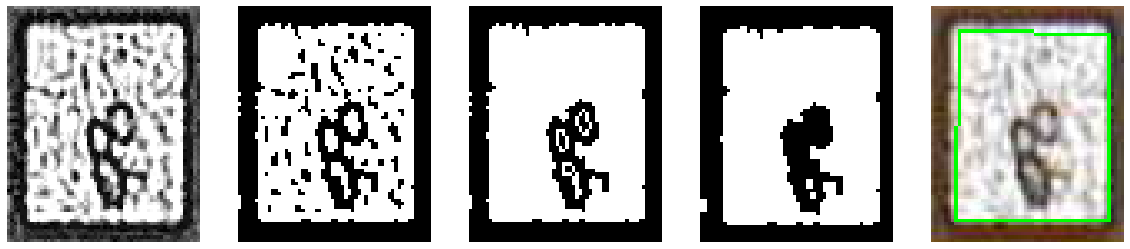

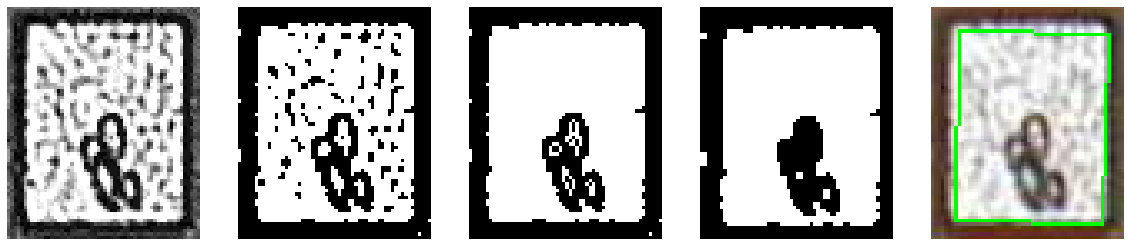

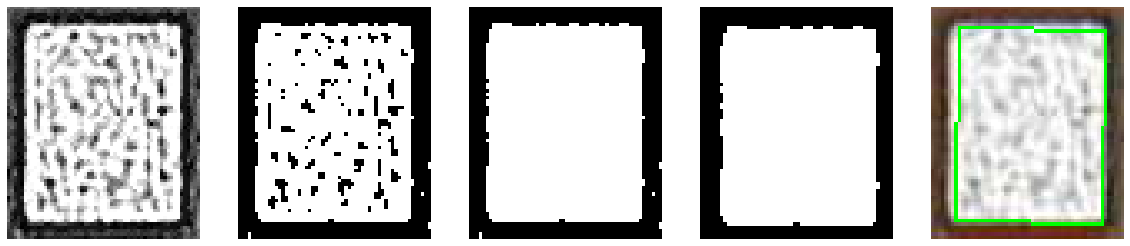

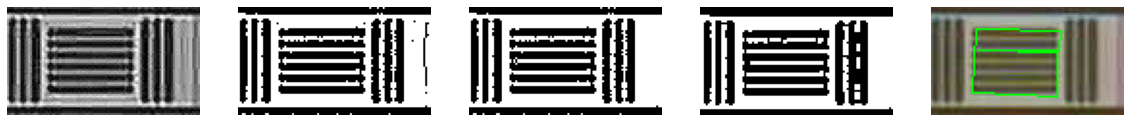

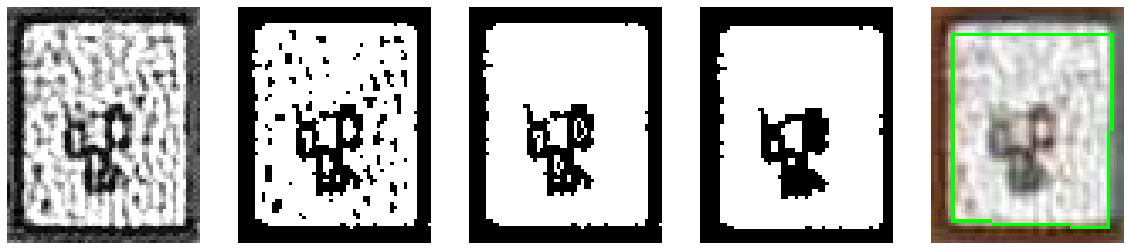

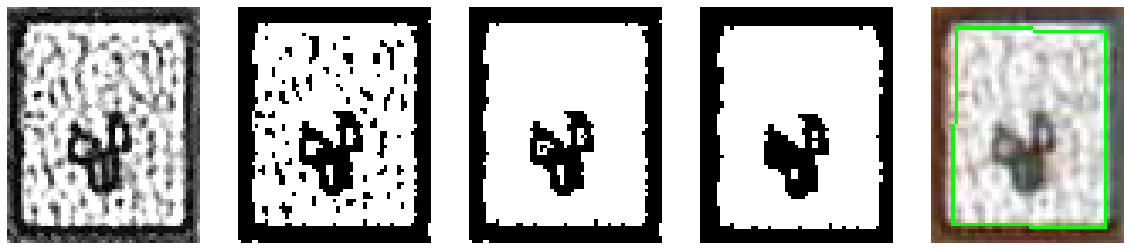

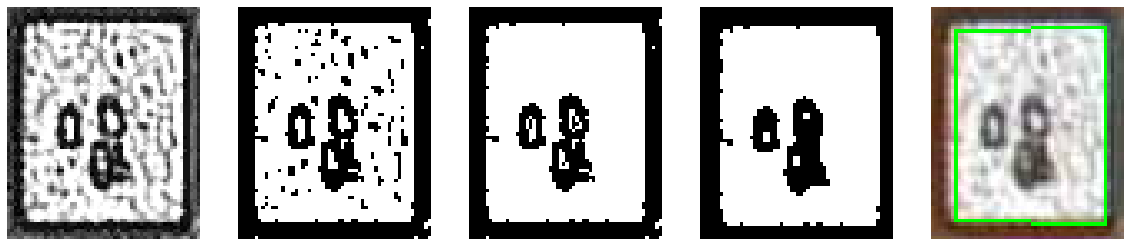

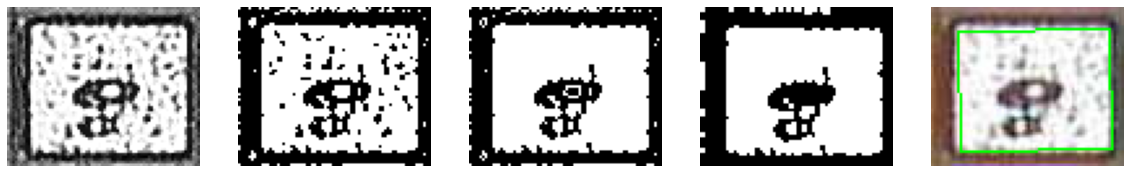

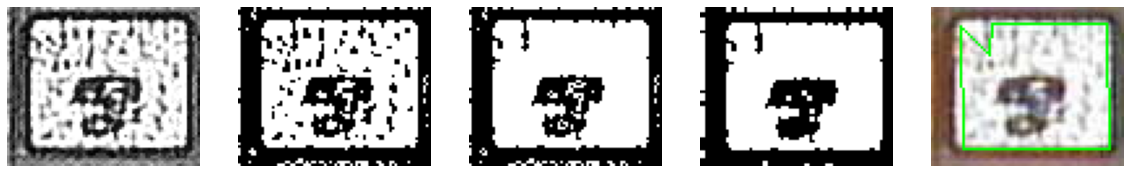

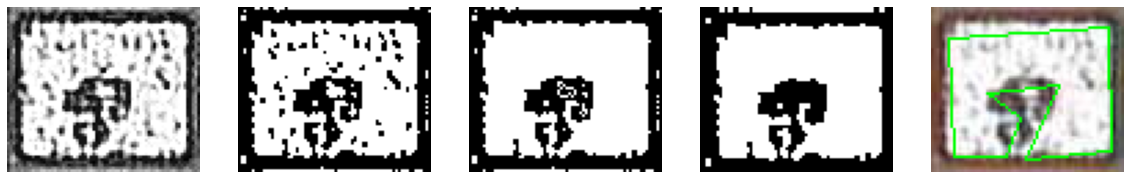

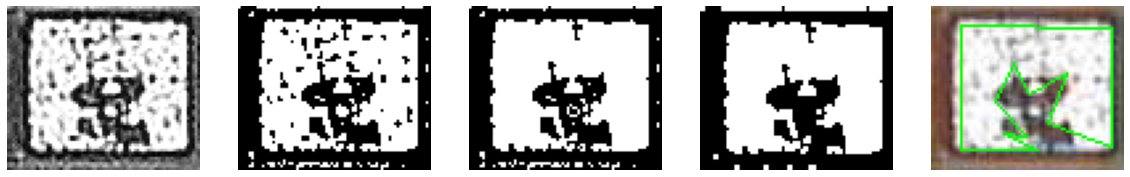

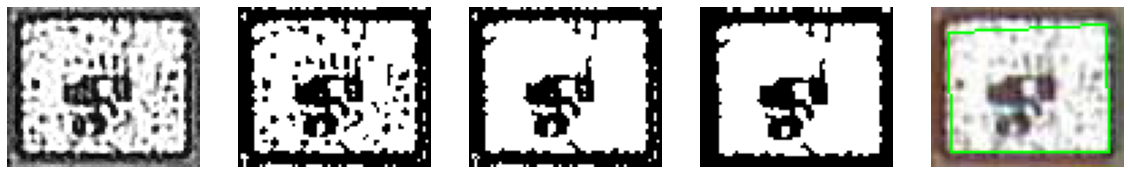

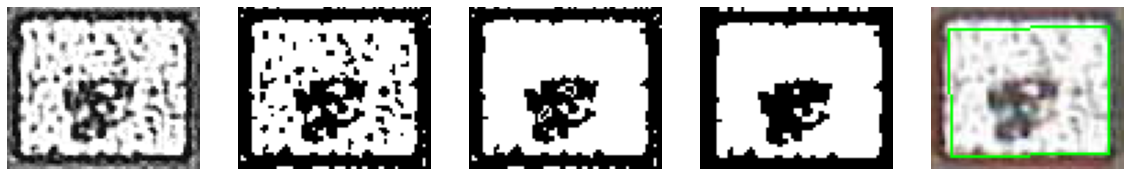

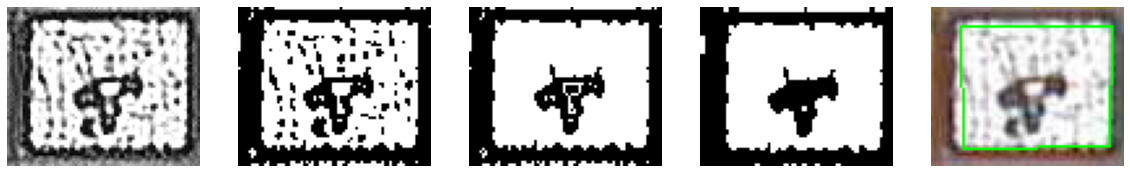

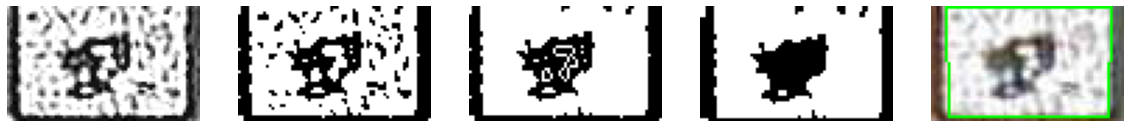

In [24]:
source_path="/tf/hsien/ai_rebin/opencv/find_square/sample/"
for dirPath,dirNames,fileNames in os.walk(source_path):
    for fileName in fileNames:
        if ".jpg" in fileName:
            file = os.path.join(dirPath,fileName)
            image = cv2.imread(file)
            touch,squares,bboxs,img,bins,image_MORPH= find_squares(image)
            for sq in squares:
                x,y,w,h = cv2.boundingRect(sq)
                h0=0 if y==0 else 1 if y==1 else 2 if y==2 else 3 if y==3 else 3 #外擴 5，但考慮有些接近邊緣只能取0~4
                w0=0 if x==0 else 1 if x==1 else 2 if x==2 else 3 if x==3 else 3
                ROI = image[y-h0:y+h+h0, x-w0:x+w+w0]
                ROI_contour,ROI_img,ROI_bins,ROI_mask,ROI_MORPH=ROI_APtouch(ROI)
                
                draw_ROI=cv2.drawContours(ROI, ROI_contour, -1, (0, 255, 0), 1)
                
                plt.figure(figsize=(20,100))
                plotimage(ROI_img, 1, 5, 1)
                plotimage(ROI_bins, 1, 5, 2)
                plotimage(ROI_mask, 1, 5, 3)
                plotimage(ROI_MORPH, 1, 5, 4)
                plotimage(draw_ROI, 1, 5, 5)
                